In [1]:
import pandas as pd
import numpy as np
import missingno as msn
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
train = pd.read_csv('train.csv')
train.sample(3)

,price,type,time,link,address,title,area,bedroom_num,house_type,toilet_num,direction,legcal_doc,block_name,total_floor,housing_feature,city,district,ward,street,description
11759,2.200000e+09,Môi giới,11/15/2019 11:13,https://nha.chotot.com//tp-ho-chi-minh/quan-12...,"đường song hành 1, Phường Tân Hưng Thuận, Quận...","dãy nhà full nội thất giá 2,2 tỷ,tiện kinh doanh",126.0,4.0,Nhà,NaN,NaN,NaN,NaN,NaN,NaN,Tp Hồ Chí Minh,Quận 12,Phường Tân Hưng Thuận,đường song hành 1,xuất cảnh nên cần bán nhanh trong tháng 2 căn ...
6000,2.800000e+09,Môi giới,11/15/2019 10:14,https://nha.chotot.com//tp-ho-chi-minh/quan-2/...,"Đường 22 Nguyễn Duy Trinh, Phường Bình Trưng T...",Nhà Quận 2 70m² p.Bình Trưng Tây 3PN gần NDT,70.0,3.0,Nhà,1.0,Bắc,Đã có sổ đỏ/sổ hồng,NaN,1,NaN,Tp Hồ Chí Minh,Quận 2,Phường Bình Trưng Tây,Đường 22 Nguyễn Duy Trinh,"Bán căn nhà rộng có gác đường 22 , p.Bình Trưn..."
9806,7.400000e+09,Môi giới,11/15/2019 11:08,https://nha.chotot.com//tp-ho-chi-minh/quan-bi...,"Đường Bùi Đình Túy, Phường 24, Quận Bình Thạnh...","Nhà 4 tầng 5PN, 5WC HXH 167 Bùi Đình Tuý, f24. BT",54.0,5.0,Nhà,5.0,NaN,Đã có sổ đỏ/sổ hồng,NaN,4,Hẻm xe hơi,Tp Hồ Chí Minh,Quận Bình Thạnh,Phường 24,Đường Bùi Đình Túy,* Bán nhà 4 tầng đường Xe hơi Đối diện UBND ph...


count    1.266600e+04
mean     3.328370e+09
std      2.366717e+09
min      1.050000e+08
25%      1.200000e+09
50%      2.800000e+09
75%      4.900000e+09
max      1.000000e+10
Name: price, dtype: float64

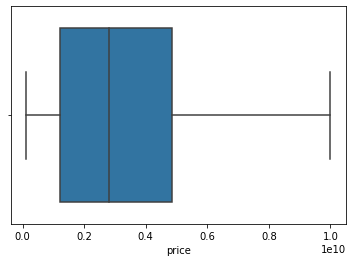

In [3]:
sns.boxplot(train[(train.price > 1e8) & (train.price < 1e10)].price)
train[(train.price >= 1e8) & (train.price <= 1e10)].price.describe()

In [4]:
train_pre1 = train[(train.price >= 1e8) & (train.price <= 1e10)].copy()
train_pre1['type'] = train_pre1['type'].apply(lambda x: x if x == 'Môi giới' else 'Khác')
train_pre1.drop(columns=['time','link','address',
                     'title','city','description',
                     'block_name','total_floor','direction'], inplace=True)

class CateCol(BaseEstimator, TransformerMixin):
    def __init__(self, col_name='price', _type=4):
        self.col_name = col_name
        self._type = _type
    def fit(self, X_df, y=None):
        details = X_df[self.col_name].describe()
        self._25 = details['25%']
        self._50 = details['50%']
        self._75 = details['75%']
        return self
    
    def to_cate(self, x):
        if self._type == 2:
            if x < self._50:
                return 0
            return 1
        
        if x < self._25:
            return 0
        if x < self._50:
            return 1
        if x < self._75:
            return 2
        return 3
    
    def transform(self, X_df, y=None):
        res_df = X_df.copy()
        res_df[self.col_name] = res_df[self.col_name].apply(lambda x: self.to_cate(x))  
        return res_df
#         res_df['type'] = res_df['type'].apply(lambda x: x if x == 'Môi giới' else 'Khác')
#         res_df.drop(columns=['price','time','link','address',
#                              'title','city','description',
#                              'block_name','total_floor','direction'], inplace=True)

In [5]:
# cate = CatePriceDrop()
# train_transform = cate.fit_transform(train)
# train_transform.sample(5)

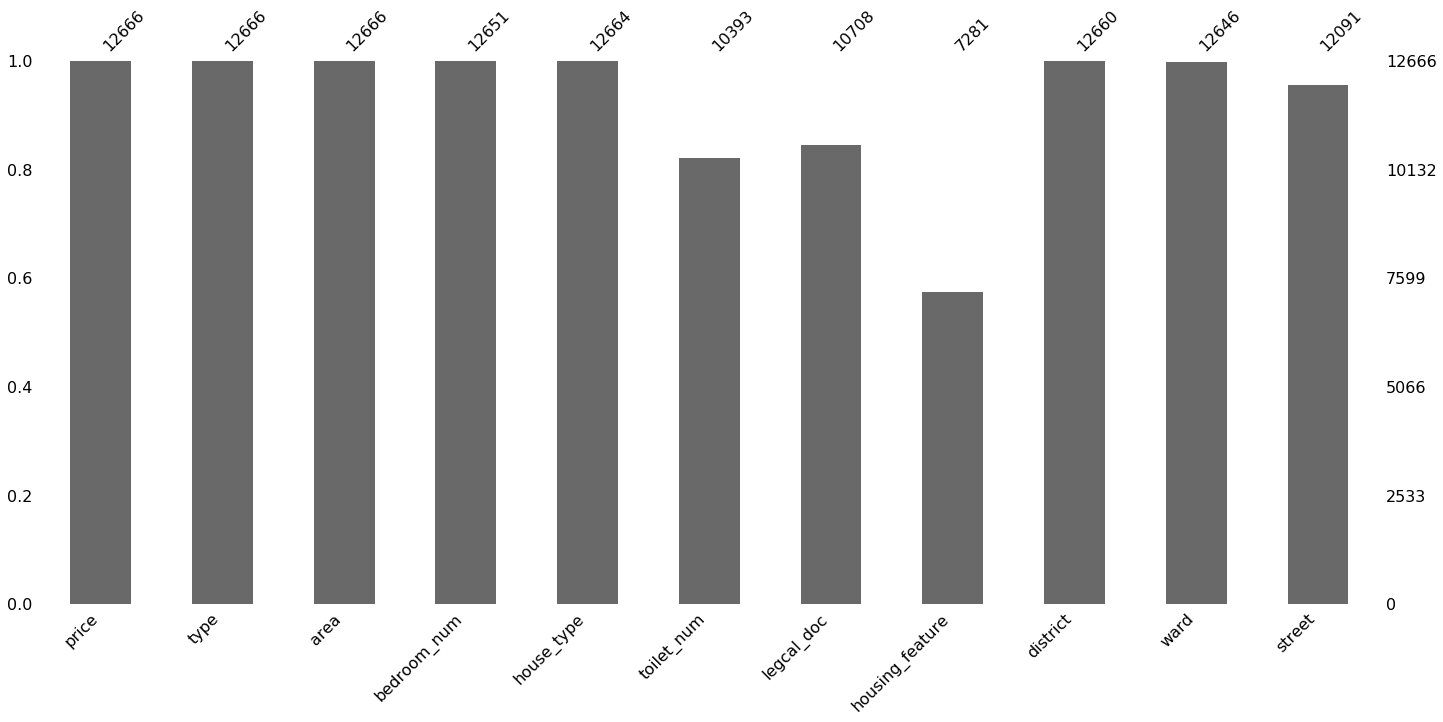

In [6]:
msn.bar(train_pre1)

In [7]:
train_pre1.toilet_num.describe()

count    10393.000000
mean         2.721832
std          1.445535
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: toilet_num, dtype: float64

In [8]:
train_pre1.legcal_doc.describe()

count                   10708
unique                      3
top       Đã có sổ đỏ/sổ hồng
freq                    10187
Name: legcal_doc, dtype: object

In [9]:
train_pre1.legcal_doc.unique()

array(['Đã có sổ đỏ/sổ hồng', nan, 'Giấy tay', 'Đang chờ bàn giao sổ'],
      dtype=object)

In [10]:
train_pre1.housing_feature.describe()

count           7281
unique             3
top       Hẻm xe hơi
freq            3357
Name: housing_feature, dtype: object

In [11]:
train_pre1.housing_feature.unique()

array(['Hẻm xe hơi', nan, 'Nở hậu', 'Mặt tiền'], dtype=object)

- Fill `toilet_num` nan with `0.0`
- Fill `legcal_doc` nan with `Không có`
- Fill `housing_feature` nan with `Khác`
- Fill `bedroom_num` nan with `0.0`
- Fill `house_type` nan with `Khác`
- Fill `district`, `ward` and `street` nan with most_frequence

In [12]:
class FillNA(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
        mode_street = X_df.street.describe()['top']
        mode_district = X_df.district.describe()['top']
        mode_ward = X_df.ward.describe()['top']
        self.mode_cols = {'street': mode_street, 
                          'district': mode_district, 
                          'ward': mode_ward}
        return self
    
    def transform(self, X_df, y=None):
        res_df = X_df.copy()
        other_cols = ['housing_feature', 'house_type']
        _0_cols = ['bedroom_num', 'toilet_num']
        for i in self.mode_cols:
            j = self.mode_cols[i]
            res_df[i].fillna(j, inplace=True)
        for i in other_cols:
            res_df[i].fillna('Khác',inplace=True)
        for i in _0_cols:
            res_df[i].fillna(0.0,inplace=True)
        res_df['legcal_doc'].fillna('Không có', inplace=True)
        return res_df

In [13]:
fillna = FillNA()
train_pre = fillna.fit_transform(train_pre1)

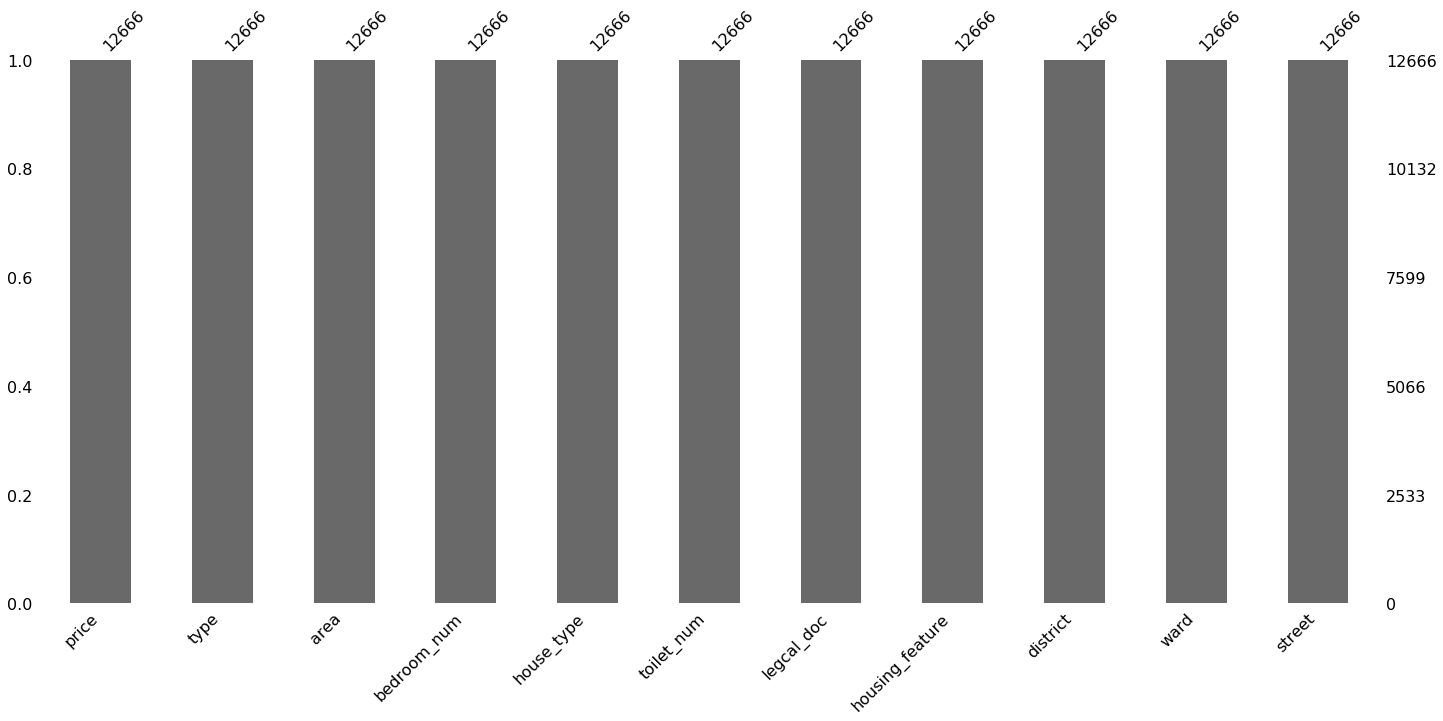

In [14]:
msn.bar(train_pre)

In [15]:
cate_cols = ['type', 'house_type', 'legcal_doc', 'housing_feature', 'district', 'ward', 'street']

scaler = StandardScaler()

pp = Pipeline(steps=[('FillNA', FillNA()), 
                     ('to_cate_price', CateCol(col_name='price', _type=2)),
                     ('to_cate_area', CateCol(col_name='area')),
                     ('to_cate_bedroom_num', CateCol(col_name='bedroom_num')),
                     ('to_cate_toilet_num', CateCol(col_name='toilet_num'))])
train_preprocess = pp.fit_transform(train_pre1)
trainY = train_preprocess['price'].values
trainX = train_preprocess.drop(columns=['price'])
onehot = OneHotEncoder(handle_unknown='ignore')
trainX = onehot.fit_transform(trainX).toarray()
trainX_Scale = scaler.fit_transform(trainX)

In [16]:
test = pd.read_csv('test.csv')

test['type'] = test['type'].apply(lambda x: x if x == 'Môi giới' else 'Khác')
test.drop(columns=['time','link','address',
                     'title','city','description',
                     'block_name','total_floor','direction'], inplace=True)


test_preprocess = pp.transform(test)
testY = test_preprocess['price'].values
testX = test_preprocess.drop(columns=['price'])
testX = onehot.transform(testX).toarray()
testX_Scale = scaler.transform(testX)
# msn.bar(testX)

In [17]:
clfs = [MLPClassifier(hidden_layer_sizes=5,max_iter=5000), DecisionTreeClassifier(), LogisticRegression(), KNeighborsClassifier()]

for clf in clfs:
    clf.fit(trainX_Scale, trainY)
    %time
    print('Train score:', clf.score(trainX_Scale, trainY))
    print('Test score:', clf.score(testX_Scale, testY))

CPU times: user 9 µs, sys: 3 µs, total: 12 µs
Wall time: 6.44 µs
Train score: 0.8810200536870362
Test score: 0.7252747252747253
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs
Train score: 0.9723669666824569
Test score: 0.7272471118624965


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
Train score: 0.7952786988788884
Test score: 0.7357001972386588
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs
Train score: 0.7922785409758408
Test score: 0.6920259227951535
